Install pandas an sklearn

In [1]:
!pip install pandas scikit-learn tensorflow


  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 1.5 MB/s eta 0:00:000:00:01m eta 0:00:01
Using cached markdown-3.8-py3-none-any.whl (106 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 1.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22/22 [tensorflow]0m 21/22 [tensorflow]it-

In [31]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Load data set to the dataframe

In [129]:
import pandas as pd
dataSetLocation = "./dataset/batch_battery_simulation_with_temp_and_degradation.csv"
dataFrame = pd.read_csv(dataSetLocation)

remove unused column (timeDiff and variant)

In [130]:
dataFrame = dataFrame.drop('TimeDiff', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Time [s]', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Variant', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('BatteryCapacity', axis=1).reset_index(drop=True)
# Drop SOC = 0
dataFrame = dataFrame[dataFrame["SOC"] > 1e-4].reset_index(drop=True)
#dataFrame = dataFrame.drop('X-averaged cell temperature [K]', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('CapacityDiff', axis=1).reset_index(drop=True)

In [131]:
print(dataFrame.head())
print(dataFrame["SOC"].min())
print(dataFrame["SOC"].max())


   Current [A]  Voltage [V]  X-averaged cell temperature [K]       SOC
0     0.833333     4.144029                       298.150000  1.000000
1     0.833333     4.139940                       298.153589  0.999769
2     0.833333     4.136843                       298.157207  0.999537
3     0.833333     4.134350                       298.160846  0.999306
4     0.833333     4.132251                       298.164499  0.999074
0.0002314814815488
1.0


Check Data Dimension

In [132]:
print(dataFrame.shape)

(172800, 4)


Check Mean,Median,Mode, Quartile, Standard Deviation

In [133]:
numeric_cols = dataFrame.select_dtypes(include=['number']).columns

stats_list = []
for col in numeric_cols:
    stats = {
        'Column': col,
        'Mean': dataFrame[col].mean(),
        'Median': dataFrame[col].median(),
        'Mode': dataFrame[col].mode().values[0] if not dataFrame[col].mode().empty else None,
        'Q1': dataFrame[col].quantile(0.25),
        'Q3': dataFrame[col].quantile(0.75),
        'Std Dev': dataFrame[col].std()
    }
    stats_list.append(stats)

descriptiveStatisticDataFrame = pd.DataFrame(stats_list)
print(descriptiveStatisticDataFrame)

                            Column        Mean      Median        Mode  \
0                      Current [A]    0.670833    0.670833    0.508333   
1                      Voltage [V]    3.803280    3.810739    2.752547   
2  X-averaged cell temperature [K]  298.469821  298.461709  298.150000   
3                              SOC    0.500116    0.500116    0.000231   

           Q1          Q3   Std Dev  
0    0.589583    0.752083  0.096195  
1    3.644207    3.999975  0.215181  
2  298.388253  298.547301  0.100881  
3    0.250174    0.750058  0.288676  


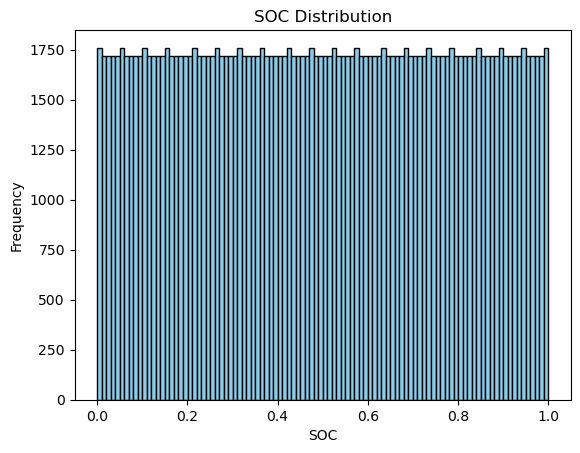

   Current [A]  Voltage [V]  X-averaged cell temperature [K]       SOC
0     0.833333     4.144029                       298.150000  1.000000
1     0.833333     4.139940                       298.153589  0.999769
2     0.833333     4.136843                       298.157207  0.999537
3     0.833333     4.134350                       298.160846  0.999306
4     0.833333     4.132251                       298.164499  0.999074


In [134]:
import matplotlib.pyplot as plt

plt.hist(dataFrame["SOC"], bins=100, color="skyblue", edgecolor="black")
plt.xlabel("SOC")
plt.ylabel("Frequency")
plt.title("SOC Distribution")
plt.show()

print(dataFrame.head())

Split X (Feature: Current, Voltage, CapacityDiff, BatteryCapacity) and Y (target: SOC)

In [135]:
Y = dataFrame['SOC']
X = dataFrame.drop('SOC', axis=1)
print("feature: ")
print(X)
print("target: ")
print(Y)

feature: 
        Current [A]  Voltage [V]  X-averaged cell temperature [K]
0          0.833333     4.144029                       298.150000
1          0.833333     4.139940                       298.153589
2          0.833333     4.136843                       298.157207
3          0.833333     4.134350                       298.160846
4          0.833333     4.132251                       298.164499
...             ...          ...                              ...
172795     0.508333     3.639226                       298.328044
172796     0.508333     3.639129                       298.328050
172797     0.508333     3.639032                       298.328056
172798     0.508333     3.638935                       298.328062
172799     0.508333     3.638838                       298.328068

[172800 rows x 3 columns]
target: 
0         1.000000
1         0.999769
2         0.999537
3         0.999306
4         0.999074
            ...   
172795    0.001157
172796    0.000926
172797    

Split 0.3 for test, 0.7 for training

In [136]:
# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=52)

Normalize

In [137]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Train & Evaluate using TensorFlow

Epoch 1/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 3s 806us/step - loss: 0.0310 - mae: 0.0652 - val_loss: 1.1483e-04 - val_mae: 0.0077
Epoch 2/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 848us/step - loss: 9.9851e-05 - mae: 0.0072 - val_loss: 7.0487e-05 - val_mae: 0.0059
Epoch 3/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - loss: 7.4572e-05 - mae: 0.0061 - val_loss: 6.9693e-05 - val_mae: 0.0063
Epoch 4/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step - loss: 5.5121e-05 - mae: 0.0054 - val_loss: 6.5893e-05 - val_mae: 0.0064
Epoch 5/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - loss: 4.3807e-05 - mae: 0.0048 - val_loss: 2.4850e-05 - val_mae: 0.0037
Epoch 6/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 789us/step - loss: 3.5180e-05 - mae: 0.0043 - val_loss: 2.1466e-05 - val_mae: 0.0035
Epoch 7/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step - loss: 2.7723e-05 - mae: 0.0038 - val_loss: 2.4188e-05 - val_mae: 0.0036
Epoch 8/100
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step - loss: 2.4261e-05 - mae: 0.00

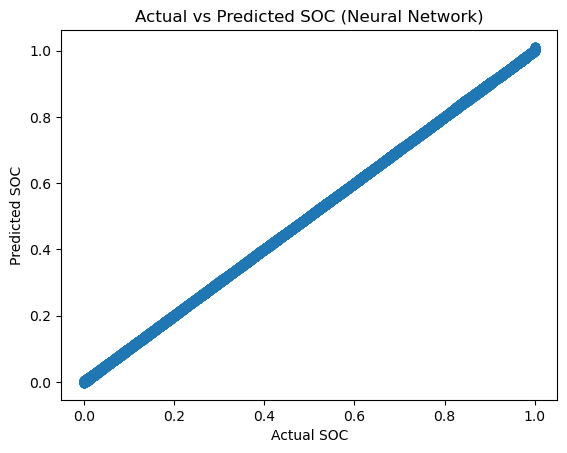

CPU times: user 4min 35s, sys: 27.6 s, total: 5min 3s
Wall time: 3min 58s


In [138]:
%%time
# Neural network Model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),  
    tf.keras.layers.Dense(16, activation='relu'),                            
    tf.keras.layers.Dense(1, activation='linear')                           
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.3, verbose=1)

# Predict on the test set
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

import matplotlib.pyplot as plt
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual SOC")
plt.ylabel("Predicted SOC")
plt.title("Actual vs Predicted SOC (Neural Network)")
plt.show()